In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join

from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset


import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import pickle

from dgl.nn import GraphConv, AvgPooling
from dgl.nn.pytorch import Sequential

from dgl.dataloading import GraphDataLoader

from sklearn.model_selection import KFold


import pickle

In [2]:
import dgl.nn.pytorch.glob

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.in_layer = GraphConv(in_feats, h_feats, activation=nn.ReLU())
#         self.relu = 
        self.inner_layer = GraphConv(h_feats, h_feats, activation=nn.ReLU())
        self.global_mean_pool = dgl.nn.pytorch.glob.AvgPooling()

        self.fc = nn.Linear(h_feats, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, g, in_feat):
        h = self.in_layer(g, in_feat)
        h = self.inner_layer(g, h)
        h = self.global_mean_pool(g, h)
#         g.ndata['h'] = h
#         h = dgl.mean_nodes(g, 'h')
        h = self.fc(h)
        
        return self.log_softmax(h)
print(GCN(4, 16, 2))


GCN(
  (in_layer): GraphConv(
    in=4, out=16, normalization=both
    (_activation): ReLU()
  )
  (inner_layer): GraphConv(
    in=16, out=16, normalization=both
    (_activation): ReLU()
  )
  (global_mean_pool): AvgPooling()
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [3]:
pickle_name = 'domain_dataset.pickle'
with open(pickle_name, 'rb') as f:
    dataset = pickle.load(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
def evaluate(model, dataloader):
    model.eval()
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in dataloader:
        pred = model(batched_graph, batched_graph.ndata['node_fv'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    return num_correct / num_tests

def train(model, device, train_loader, optimizer, epoch, training=True):
    if training:
        model.train()
    else:
        model.eval()
#     print(train_loader)
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, data.ndata['node_fv'].float())
        loss = F.nll_loss(output, target)
        if not training:
            return loss.item()
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    

In [6]:
splits=KFold(n_splits=10,shuffle=True,random_state=42)
foldperf={}
num_epochs=200

In [7]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))
    

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = GraphDataLoader(dataset, batch_size=1000, sampler=train_sampler)
    test_loader = GraphDataLoader(dataset, batch_size=1000, sampler=test_sampler)
    
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#     model = ConvNet()
    model = GCN(4, 16, 2)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
# def train(model, device, train_loader, optimizer, epoch, training=True):
# def evaluate(model, dataloader):
    for epoch in range(num_epochs):
        
        train_loss =train(model,device,train_loader,optimizer, epoch, True)
        train_acc = evaluate(model, train_loader)
        test_loss=train(model,device,test_loader,optimizer, epoch, False)
        test_acc = evaluate(model, test_loader)

#         train_loss = train_loss / len(train_loader.sampler)
#         test_loss = test_loss / len(test_loader.sampler)
#         test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  


Fold 1
Epoch:1/200 AVG Training Loss:0.694 AVG Test Loss:0.683 AVG Training Acc 0.57 % AVG Test Acc 0.60 %
Epoch:2/200 AVG Training Loss:0.687 AVG Test Loss:0.656 AVG Training Acc 0.62 % AVG Test Acc 0.64 %


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch:3/200 AVG Training Loss:0.671 AVG Test Loss:0.656 AVG Training Acc 0.61 % AVG Test Acc 0.64 %
Epoch:4/200 AVG Training Loss:0.680 AVG Test Loss:0.653 AVG Training Acc 0.65 % AVG Test Acc 0.68 %
Epoch:5/200 AVG Training Loss:0.691 AVG Test Loss:0.640 AVG Training Acc 0.63 % AVG Test Acc 0.64 %
Epoch:6/200 AVG Training Loss:0.667 AVG Test Loss:0.655 AVG Training Acc 0.61 % AVG Test Acc 0.64 %
Epoch:7/200 AVG Training Loss:0.671 AVG Test Loss:0.658 AVG Training Acc 0.61 % AVG Test Acc 0.60 %
Epoch:8/200 AVG Training Loss:0.672 AVG Test Loss:0.657 AVG Training Acc 0.61 % AVG Test Acc 0.64 %
Epoch:9/200 AVG Training Loss:0.669 AVG Test Loss:0.661 AVG Training Acc 0.63 % AVG Test Acc 0.64 %
Epoch:10/200 AVG Training Loss:0.671 AVG Test Loss:0.662 AVG Training Acc 0.65 % AVG Test Acc 0.68 %
Epoch:11/200 AVG Training Loss:0.673 AVG Test Loss:0.658 AVG Training Acc 0.65 % AVG Test Acc 0.68 %
Epoch:12/200 AVG Training Loss:0.670 AVG Test Loss:0.651 AVG Training Acc 0.61 % AVG Test Acc 0.64

Epoch:86/200 AVG Training Loss:0.627 AVG Test Loss:0.653 AVG Training Acc 0.61 % AVG Test Acc 0.68 %
Epoch:87/200 AVG Training Loss:0.628 AVG Test Loss:0.656 AVG Training Acc 0.64 % AVG Test Acc 0.68 %
Epoch:88/200 AVG Training Loss:0.626 AVG Test Loss:0.656 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:89/200 AVG Training Loss:0.627 AVG Test Loss:0.651 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:90/200 AVG Training Loss:0.627 AVG Test Loss:0.651 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:91/200 AVG Training Loss:0.627 AVG Test Loss:0.651 AVG Training Acc 0.61 % AVG Test Acc 0.68 %
Epoch:92/200 AVG Training Loss:0.626 AVG Test Loss:0.659 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:93/200 AVG Training Loss:0.625 AVG Test Loss:0.666 AVG Training Acc 0.64 % AVG Test Acc 0.68 %
Epoch:94/200 AVG Training Loss:0.626 AVG Test Loss:0.659 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:95/200 AVG Training Loss:0.626 AVG Test Loss:0.656 AVG Training Acc 0.64 % AVG Test A

Epoch:169/200 AVG Training Loss:0.626 AVG Test Loss:0.673 AVG Training Acc 0.64 % AVG Test Acc 0.60 %
Epoch:170/200 AVG Training Loss:0.627 AVG Test Loss:0.663 AVG Training Acc 0.65 % AVG Test Acc 0.60 %
Epoch:171/200 AVG Training Loss:0.624 AVG Test Loss:0.657 AVG Training Acc 0.64 % AVG Test Acc 0.60 %
Epoch:172/200 AVG Training Loss:0.620 AVG Test Loss:0.659 AVG Training Acc 0.66 % AVG Test Acc 0.64 %
Epoch:173/200 AVG Training Loss:0.620 AVG Test Loss:0.671 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:174/200 AVG Training Loss:0.620 AVG Test Loss:0.681 AVG Training Acc 0.61 % AVG Test Acc 0.60 %
Epoch:175/200 AVG Training Loss:0.621 AVG Test Loss:0.689 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:176/200 AVG Training Loss:0.618 AVG Test Loss:0.696 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:177/200 AVG Training Loss:0.620 AVG Test Loss:0.696 AVG Training Acc 0.64 % AVG Test Acc 0.68 %
Epoch:178/200 AVG Training Loss:0.618 AVG Test Loss:0.687 AVG Training Acc 0.62 % 

Epoch:52/200 AVG Training Loss:0.637 AVG Test Loss:0.555 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:53/200 AVG Training Loss:0.633 AVG Test Loss:0.558 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:54/200 AVG Training Loss:0.633 AVG Test Loss:0.561 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:55/200 AVG Training Loss:0.635 AVG Test Loss:0.557 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:56/200 AVG Training Loss:0.632 AVG Test Loss:0.558 AVG Training Acc 0.61 % AVG Test Acc 0.72 %
Epoch:57/200 AVG Training Loss:0.634 AVG Test Loss:0.554 AVG Training Acc 0.62 % AVG Test Acc 0.72 %
Epoch:58/200 AVG Training Loss:0.632 AVG Test Loss:0.554 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:59/200 AVG Training Loss:0.633 AVG Test Loss:0.555 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:60/200 AVG Training Loss:0.633 AVG Test Loss:0.555 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:61/200 AVG Training Loss:0.632 AVG Test Loss:0.559 AVG Training Acc 0.63 % AVG Test A

Epoch:136/200 AVG Training Loss:0.627 AVG Test Loss:0.546 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:137/200 AVG Training Loss:0.627 AVG Test Loss:0.547 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:138/200 AVG Training Loss:0.627 AVG Test Loss:0.550 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:139/200 AVG Training Loss:0.628 AVG Test Loss:0.547 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:140/200 AVG Training Loss:0.627 AVG Test Loss:0.544 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:141/200 AVG Training Loss:0.627 AVG Test Loss:0.544 AVG Training Acc 0.62 % AVG Test Acc 0.72 %
Epoch:142/200 AVG Training Loss:0.627 AVG Test Loss:0.546 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:143/200 AVG Training Loss:0.627 AVG Test Loss:0.547 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:144/200 AVG Training Loss:0.627 AVG Test Loss:0.546 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:145/200 AVG Training Loss:0.626 AVG Test Loss:0.546 AVG Training Acc 0.64 % 

Epoch:20/200 AVG Training Loss:0.645 AVG Test Loss:0.677 AVG Training Acc 0.60 % AVG Test Acc 0.68 %
Epoch:21/200 AVG Training Loss:0.647 AVG Test Loss:0.687 AVG Training Acc 0.60 % AVG Test Acc 0.56 %
Epoch:22/200 AVG Training Loss:0.644 AVG Test Loss:0.685 AVG Training Acc 0.62 % AVG Test Acc 0.52 %
Epoch:23/200 AVG Training Loss:0.645 AVG Test Loss:0.686 AVG Training Acc 0.61 % AVG Test Acc 0.60 %
Epoch:24/200 AVG Training Loss:0.643 AVG Test Loss:0.693 AVG Training Acc 0.61 % AVG Test Acc 0.64 %
Epoch:25/200 AVG Training Loss:0.645 AVG Test Loss:0.682 AVG Training Acc 0.61 % AVG Test Acc 0.68 %
Epoch:26/200 AVG Training Loss:0.644 AVG Test Loss:0.675 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:27/200 AVG Training Loss:0.643 AVG Test Loss:0.671 AVG Training Acc 0.61 % AVG Test Acc 0.56 %
Epoch:28/200 AVG Training Loss:0.642 AVG Test Loss:0.674 AVG Training Acc 0.60 % AVG Test Acc 0.60 %
Epoch:29/200 AVG Training Loss:0.641 AVG Test Loss:0.683 AVG Training Acc 0.60 % AVG Test A

Epoch:104/200 AVG Training Loss:0.616 AVG Test Loss:0.661 AVG Training Acc 0.63 % AVG Test Acc 0.56 %
Epoch:105/200 AVG Training Loss:0.617 AVG Test Loss:0.658 AVG Training Acc 0.63 % AVG Test Acc 0.64 %
Epoch:106/200 AVG Training Loss:0.615 AVG Test Loss:0.665 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:107/200 AVG Training Loss:0.615 AVG Test Loss:0.672 AVG Training Acc 0.65 % AVG Test Acc 0.72 %
Epoch:108/200 AVG Training Loss:0.617 AVG Test Loss:0.660 AVG Training Acc 0.63 % AVG Test Acc 0.52 %
Epoch:109/200 AVG Training Loss:0.627 AVG Test Loss:0.649 AVG Training Acc 0.62 % AVG Test Acc 0.56 %
Epoch:110/200 AVG Training Loss:0.617 AVG Test Loss:0.681 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:111/200 AVG Training Loss:0.619 AVG Test Loss:0.678 AVG Training Acc 0.65 % AVG Test Acc 0.72 %
Epoch:112/200 AVG Training Loss:0.618 AVG Test Loss:0.654 AVG Training Acc 0.63 % AVG Test Acc 0.52 %
Epoch:113/200 AVG Training Loss:0.621 AVG Test Loss:0.656 AVG Training Acc 0.63 % 

Epoch:188/200 AVG Training Loss:0.632 AVG Test Loss:0.703 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:189/200 AVG Training Loss:0.630 AVG Test Loss:0.707 AVG Training Acc 0.62 % AVG Test Acc 0.56 %
Epoch:190/200 AVG Training Loss:0.635 AVG Test Loss:0.711 AVG Training Acc 0.62 % AVG Test Acc 0.64 %
Epoch:191/200 AVG Training Loss:0.633 AVG Test Loss:0.718 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:192/200 AVG Training Loss:0.628 AVG Test Loss:0.731 AVG Training Acc 0.62 % AVG Test Acc 0.72 %
Epoch:193/200 AVG Training Loss:0.629 AVG Test Loss:0.738 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:194/200 AVG Training Loss:0.629 AVG Test Loss:0.724 AVG Training Acc 0.62 % AVG Test Acc 0.72 %
Epoch:195/200 AVG Training Loss:0.624 AVG Test Loss:0.716 AVG Training Acc 0.62 % AVG Test Acc 0.64 %
Epoch:196/200 AVG Training Loss:0.624 AVG Test Loss:0.715 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:197/200 AVG Training Loss:0.624 AVG Test Loss:0.717 AVG Training Acc 0.63 % 

Epoch:70/200 AVG Training Loss:0.623 AVG Test Loss:0.685 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:71/200 AVG Training Loss:0.622 AVG Test Loss:0.687 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:72/200 AVG Training Loss:0.621 AVG Test Loss:0.685 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:73/200 AVG Training Loss:0.620 AVG Test Loss:0.682 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:74/200 AVG Training Loss:0.621 AVG Test Loss:0.691 AVG Training Acc 0.64 % AVG Test Acc 0.52 %
Epoch:75/200 AVG Training Loss:0.619 AVG Test Loss:0.697 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:76/200 AVG Training Loss:0.620 AVG Test Loss:0.687 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:77/200 AVG Training Loss:0.620 AVG Test Loss:0.687 AVG Training Acc 0.65 % AVG Test Acc 0.56 %
Epoch:78/200 AVG Training Loss:0.618 AVG Test Loss:0.705 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:79/200 AVG Training Loss:0.624 AVG Test Loss:0.681 AVG Training Acc 0.63 % AVG Test A

Epoch:154/200 AVG Training Loss:0.616 AVG Test Loss:0.715 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:155/200 AVG Training Loss:0.615 AVG Test Loss:0.712 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:156/200 AVG Training Loss:0.616 AVG Test Loss:0.712 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:157/200 AVG Training Loss:0.614 AVG Test Loss:0.714 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:158/200 AVG Training Loss:0.613 AVG Test Loss:0.705 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:159/200 AVG Training Loss:0.615 AVG Test Loss:0.695 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:160/200 AVG Training Loss:0.613 AVG Test Loss:0.692 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:161/200 AVG Training Loss:0.614 AVG Test Loss:0.693 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:162/200 AVG Training Loss:0.612 AVG Test Loss:0.701 AVG Training Acc 0.65 % AVG Test Acc 0.52 %
Epoch:163/200 AVG Training Loss:0.610 AVG Test Loss:0.703 AVG Training Acc 0.65 % 

Epoch:36/200 AVG Training Loss:0.634 AVG Test Loss:0.607 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:37/200 AVG Training Loss:0.634 AVG Test Loss:0.605 AVG Training Acc 0.64 % AVG Test Acc 0.72 %
Epoch:38/200 AVG Training Loss:0.634 AVG Test Loss:0.612 AVG Training Acc 0.62 % AVG Test Acc 0.68 %
Epoch:39/200 AVG Training Loss:0.634 AVG Test Loss:0.604 AVG Training Acc 0.64 % AVG Test Acc 0.68 %
Epoch:40/200 AVG Training Loss:0.630 AVG Test Loss:0.595 AVG Training Acc 0.63 % AVG Test Acc 0.72 %
Epoch:41/200 AVG Training Loss:0.631 AVG Test Loss:0.597 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:42/200 AVG Training Loss:0.631 AVG Test Loss:0.594 AVG Training Acc 0.63 % AVG Test Acc 0.68 %
Epoch:43/200 AVG Training Loss:0.628 AVG Test Loss:0.603 AVG Training Acc 0.64 % AVG Test Acc 0.68 %
Epoch:44/200 AVG Training Loss:0.628 AVG Test Loss:0.611 AVG Training Acc 0.63 % AVG Test Acc 0.64 %
Epoch:45/200 AVG Training Loss:0.632 AVG Test Loss:0.609 AVG Training Acc 0.64 % AVG Test A

Epoch:118/200 AVG Training Loss:0.616 AVG Test Loss:0.596 AVG Training Acc 0.65 % AVG Test Acc 0.72 %
Epoch:119/200 AVG Training Loss:0.616 AVG Test Loss:0.597 AVG Training Acc 0.65 % AVG Test Acc 0.72 %
Epoch:120/200 AVG Training Loss:0.615 AVG Test Loss:0.597 AVG Training Acc 0.66 % AVG Test Acc 0.72 %
Epoch:121/200 AVG Training Loss:0.610 AVG Test Loss:0.610 AVG Training Acc 0.66 % AVG Test Acc 0.68 %
Epoch:122/200 AVG Training Loss:0.614 AVG Test Loss:0.597 AVG Training Acc 0.66 % AVG Test Acc 0.72 %
Epoch:123/200 AVG Training Loss:0.607 AVG Test Loss:0.598 AVG Training Acc 0.66 % AVG Test Acc 0.72 %
Epoch:124/200 AVG Training Loss:0.605 AVG Test Loss:0.614 AVG Training Acc 0.66 % AVG Test Acc 0.68 %
Epoch:125/200 AVG Training Loss:0.605 AVG Test Loss:0.596 AVG Training Acc 0.66 % AVG Test Acc 0.72 %
Epoch:126/200 AVG Training Loss:0.609 AVG Test Loss:0.600 AVG Training Acc 0.66 % AVG Test Acc 0.68 %
Epoch:127/200 AVG Training Loss:0.607 AVG Test Loss:0.601 AVG Training Acc 0.66 % 

Epoch:200/200 AVG Training Loss:0.605 AVG Test Loss:0.606 AVG Training Acc 0.66 % AVG Test Acc 0.68 %
Fold 6
Epoch:1/200 AVG Training Loss:0.699 AVG Test Loss:0.698 AVG Training Acc 0.52 % AVG Test Acc 0.58 %
Epoch:2/200 AVG Training Loss:0.687 AVG Test Loss:0.788 AVG Training Acc 0.48 % AVG Test Acc 0.42 %
Epoch:3/200 AVG Training Loss:0.685 AVG Test Loss:0.735 AVG Training Acc 0.67 % AVG Test Acc 0.46 %
Epoch:4/200 AVG Training Loss:0.662 AVG Test Loss:0.813 AVG Training Acc 0.65 % AVG Test Acc 0.42 %
Epoch:5/200 AVG Training Loss:0.644 AVG Test Loss:0.957 AVG Training Acc 0.64 % AVG Test Acc 0.38 %
Epoch:6/200 AVG Training Loss:0.657 AVG Test Loss:0.909 AVG Training Acc 0.64 % AVG Test Acc 0.38 %
Epoch:7/200 AVG Training Loss:0.651 AVG Test Loss:0.821 AVG Training Acc 0.64 % AVG Test Acc 0.38 %
Epoch:8/200 AVG Training Loss:0.645 AVG Test Loss:0.769 AVG Training Acc 0.64 % AVG Test Acc 0.38 %
Epoch:9/200 AVG Training Loss:0.647 AVG Test Loss:0.754 AVG Training Acc 0.64 % AVG Test Ac

Epoch:83/200 AVG Training Loss:0.608 AVG Test Loss:0.751 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:84/200 AVG Training Loss:0.608 AVG Test Loss:0.747 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:85/200 AVG Training Loss:0.607 AVG Test Loss:0.743 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:86/200 AVG Training Loss:0.607 AVG Test Loss:0.737 AVG Training Acc 0.66 % AVG Test Acc 0.38 %
Epoch:87/200 AVG Training Loss:0.607 AVG Test Loss:0.749 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:88/200 AVG Training Loss:0.606 AVG Test Loss:0.761 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:89/200 AVG Training Loss:0.606 AVG Test Loss:0.752 AVG Training Acc 0.66 % AVG Test Acc 0.38 %
Epoch:90/200 AVG Training Loss:0.606 AVG Test Loss:0.746 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:91/200 AVG Training Loss:0.605 AVG Test Loss:0.734 AVG Training Acc 0.66 % AVG Test Acc 0.38 %
Epoch:92/200 AVG Training Loss:0.607 AVG Test Loss:0.731 AVG Training Acc 0.66 % AVG Test A

Epoch:167/200 AVG Training Loss:0.599 AVG Test Loss:0.815 AVG Training Acc 0.67 % AVG Test Acc 0.42 %
Epoch:168/200 AVG Training Loss:0.601 AVG Test Loss:0.773 AVG Training Acc 0.68 % AVG Test Acc 0.50 %
Epoch:169/200 AVG Training Loss:0.600 AVG Test Loss:0.805 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:170/200 AVG Training Loss:0.598 AVG Test Loss:0.862 AVG Training Acc 0.66 % AVG Test Acc 0.42 %
Epoch:171/200 AVG Training Loss:0.601 AVG Test Loss:0.797 AVG Training Acc 0.67 % AVG Test Acc 0.46 %
Epoch:172/200 AVG Training Loss:0.593 AVG Test Loss:0.759 AVG Training Acc 0.68 % AVG Test Acc 0.54 %
Epoch:173/200 AVG Training Loss:0.596 AVG Test Loss:0.812 AVG Training Acc 0.66 % AVG Test Acc 0.46 %
Epoch:174/200 AVG Training Loss:0.592 AVG Test Loss:0.807 AVG Training Acc 0.66 % AVG Test Acc 0.46 %
Epoch:175/200 AVG Training Loss:0.596 AVG Test Loss:0.773 AVG Training Acc 0.68 % AVG Test Acc 0.58 %
Epoch:176/200 AVG Training Loss:0.592 AVG Test Loss:0.770 AVG Training Acc 0.67 % 

Epoch:50/200 AVG Training Loss:0.629 AVG Test Loss:0.706 AVG Training Acc 0.62 % AVG Test Acc 0.62 %
Epoch:51/200 AVG Training Loss:0.626 AVG Test Loss:0.697 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:52/200 AVG Training Loss:0.623 AVG Test Loss:0.712 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:53/200 AVG Training Loss:0.624 AVG Test Loss:0.723 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:54/200 AVG Training Loss:0.627 AVG Test Loss:0.719 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:55/200 AVG Training Loss:0.626 AVG Test Loss:0.696 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:56/200 AVG Training Loss:0.626 AVG Test Loss:0.693 AVG Training Acc 0.62 % AVG Test Acc 0.62 %
Epoch:57/200 AVG Training Loss:0.628 AVG Test Loss:0.718 AVG Training Acc 0.62 % AVG Test Acc 0.67 %
Epoch:58/200 AVG Training Loss:0.629 AVG Test Loss:0.722 AVG Training Acc 0.62 % AVG Test Acc 0.67 %
Epoch:59/200 AVG Training Loss:0.629 AVG Test Loss:0.699 AVG Training Acc 0.62 % AVG Test A

Epoch:132/200 AVG Training Loss:0.611 AVG Test Loss:0.703 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:133/200 AVG Training Loss:0.611 AVG Test Loss:0.688 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:134/200 AVG Training Loss:0.612 AVG Test Loss:0.704 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:135/200 AVG Training Loss:0.611 AVG Test Loss:0.706 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:136/200 AVG Training Loss:0.611 AVG Test Loss:0.691 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:137/200 AVG Training Loss:0.611 AVG Test Loss:0.697 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:138/200 AVG Training Loss:0.611 AVG Test Loss:0.713 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:139/200 AVG Training Loss:0.612 AVG Test Loss:0.708 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:140/200 AVG Training Loss:0.611 AVG Test Loss:0.688 AVG Training Acc 0.66 % AVG Test Acc 0.62 %
Epoch:141/200 AVG Training Loss:0.612 AVG Test Loss:0.701 AVG Training Acc 0.66 % 

Epoch:15/200 AVG Training Loss:0.665 AVG Test Loss:0.674 AVG Training Acc 0.62 % AVG Test Acc 0.54 %
Epoch:16/200 AVG Training Loss:0.666 AVG Test Loss:0.675 AVG Training Acc 0.63 % AVG Test Acc 0.54 %
Epoch:17/200 AVG Training Loss:0.663 AVG Test Loss:0.681 AVG Training Acc 0.62 % AVG Test Acc 0.54 %
Epoch:18/200 AVG Training Loss:0.661 AVG Test Loss:0.687 AVG Training Acc 0.63 % AVG Test Acc 0.58 %
Epoch:19/200 AVG Training Loss:0.663 AVG Test Loss:0.690 AVG Training Acc 0.64 % AVG Test Acc 0.58 %
Epoch:20/200 AVG Training Loss:0.663 AVG Test Loss:0.687 AVG Training Acc 0.63 % AVG Test Acc 0.58 %
Epoch:21/200 AVG Training Loss:0.661 AVG Test Loss:0.681 AVG Training Acc 0.62 % AVG Test Acc 0.54 %
Epoch:22/200 AVG Training Loss:0.660 AVG Test Loss:0.678 AVG Training Acc 0.63 % AVG Test Acc 0.54 %
Epoch:23/200 AVG Training Loss:0.661 AVG Test Loss:0.679 AVG Training Acc 0.63 % AVG Test Acc 0.54 %
Epoch:24/200 AVG Training Loss:0.660 AVG Test Loss:0.683 AVG Training Acc 0.62 % AVG Test A

Epoch:100/200 AVG Training Loss:0.624 AVG Test Loss:0.706 AVG Training Acc 0.64 % AVG Test Acc 0.58 %
Epoch:101/200 AVG Training Loss:0.628 AVG Test Loss:0.686 AVG Training Acc 0.66 % AVG Test Acc 0.50 %
Epoch:102/200 AVG Training Loss:0.625 AVG Test Loss:0.689 AVG Training Acc 0.65 % AVG Test Acc 0.50 %
Epoch:103/200 AVG Training Loss:0.623 AVG Test Loss:0.695 AVG Training Acc 0.64 % AVG Test Acc 0.50 %
Epoch:104/200 AVG Training Loss:0.624 AVG Test Loss:0.689 AVG Training Acc 0.64 % AVG Test Acc 0.50 %
Epoch:105/200 AVG Training Loss:0.623 AVG Test Loss:0.688 AVG Training Acc 0.66 % AVG Test Acc 0.50 %
Epoch:106/200 AVG Training Loss:0.623 AVG Test Loss:0.693 AVG Training Acc 0.64 % AVG Test Acc 0.46 %
Epoch:107/200 AVG Training Loss:0.623 AVG Test Loss:0.695 AVG Training Acc 0.64 % AVG Test Acc 0.46 %
Epoch:108/200 AVG Training Loss:0.622 AVG Test Loss:0.694 AVG Training Acc 0.64 % AVG Test Acc 0.46 %
Epoch:109/200 AVG Training Loss:0.622 AVG Test Loss:0.699 AVG Training Acc 0.64 % 

Epoch:183/200 AVG Training Loss:0.624 AVG Test Loss:0.693 AVG Training Acc 0.64 % AVG Test Acc 0.46 %
Epoch:184/200 AVG Training Loss:0.617 AVG Test Loss:0.690 AVG Training Acc 0.68 % AVG Test Acc 0.54 %
Epoch:185/200 AVG Training Loss:0.622 AVG Test Loss:0.725 AVG Training Acc 0.64 % AVG Test Acc 0.54 %
Epoch:186/200 AVG Training Loss:0.628 AVG Test Loss:0.699 AVG Training Acc 0.67 % AVG Test Acc 0.54 %
Epoch:187/200 AVG Training Loss:0.618 AVG Test Loss:0.690 AVG Training Acc 0.68 % AVG Test Acc 0.50 %
Epoch:188/200 AVG Training Loss:0.626 AVG Test Loss:0.724 AVG Training Acc 0.64 % AVG Test Acc 0.54 %
Epoch:189/200 AVG Training Loss:0.628 AVG Test Loss:0.706 AVG Training Acc 0.65 % AVG Test Acc 0.54 %
Epoch:190/200 AVG Training Loss:0.619 AVG Test Loss:0.691 AVG Training Acc 0.68 % AVG Test Acc 0.54 %
Epoch:191/200 AVG Training Loss:0.627 AVG Test Loss:0.696 AVG Training Acc 0.65 % AVG Test Acc 0.46 %
Epoch:192/200 AVG Training Loss:0.618 AVG Test Loss:0.712 AVG Training Acc 0.65 % 

Epoch:66/200 AVG Training Loss:0.637 AVG Test Loss:0.718 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:67/200 AVG Training Loss:0.637 AVG Test Loss:0.719 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:68/200 AVG Training Loss:0.637 AVG Test Loss:0.720 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:69/200 AVG Training Loss:0.638 AVG Test Loss:0.713 AVG Training Acc 0.62 % AVG Test Acc 0.62 %
Epoch:70/200 AVG Training Loss:0.638 AVG Test Loss:0.710 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:71/200 AVG Training Loss:0.639 AVG Test Loss:0.708 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:72/200 AVG Training Loss:0.636 AVG Test Loss:0.716 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:73/200 AVG Training Loss:0.639 AVG Test Loss:0.709 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:74/200 AVG Training Loss:0.636 AVG Test Loss:0.715 AVG Training Acc 0.62 % AVG Test Acc 0.58 %
Epoch:75/200 AVG Training Loss:0.639 AVG Test Loss:0.717 AVG Training Acc 0.62 % AVG Test A

Epoch:149/200 AVG Training Loss:0.637 AVG Test Loss:0.686 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:150/200 AVG Training Loss:0.636 AVG Test Loss:0.696 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:151/200 AVG Training Loss:0.638 AVG Test Loss:0.704 AVG Training Acc 0.62 % AVG Test Acc 0.58 %
Epoch:152/200 AVG Training Loss:0.637 AVG Test Loss:0.704 AVG Training Acc 0.62 % AVG Test Acc 0.58 %
Epoch:153/200 AVG Training Loss:0.638 AVG Test Loss:0.700 AVG Training Acc 0.62 % AVG Test Acc 0.62 %
Epoch:154/200 AVG Training Loss:0.634 AVG Test Loss:0.703 AVG Training Acc 0.63 % AVG Test Acc 0.62 %
Epoch:155/200 AVG Training Loss:0.638 AVG Test Loss:0.701 AVG Training Acc 0.63 % AVG Test Acc 0.58 %
Epoch:156/200 AVG Training Loss:0.632 AVG Test Loss:0.709 AVG Training Acc 0.63 % AVG Test Acc 0.58 %
Epoch:157/200 AVG Training Loss:0.638 AVG Test Loss:0.702 AVG Training Acc 0.62 % AVG Test Acc 0.58 %
Epoch:158/200 AVG Training Loss:0.633 AVG Test Loss:0.702 AVG Training Acc 0.62 % 

Epoch:31/200 AVG Training Loss:0.653 AVG Test Loss:0.613 AVG Training Acc 0.61 % AVG Test Acc 0.71 %
Epoch:32/200 AVG Training Loss:0.652 AVG Test Loss:0.608 AVG Training Acc 0.61 % AVG Test Acc 0.71 %
Epoch:33/200 AVG Training Loss:0.650 AVG Test Loss:0.600 AVG Training Acc 0.61 % AVG Test Acc 0.71 %
Epoch:34/200 AVG Training Loss:0.648 AVG Test Loss:0.592 AVG Training Acc 0.62 % AVG Test Acc 0.71 %
Epoch:35/200 AVG Training Loss:0.647 AVG Test Loss:0.592 AVG Training Acc 0.62 % AVG Test Acc 0.75 %
Epoch:36/200 AVG Training Loss:0.645 AVG Test Loss:0.597 AVG Training Acc 0.62 % AVG Test Acc 0.71 %
Epoch:37/200 AVG Training Loss:0.644 AVG Test Loss:0.591 AVG Training Acc 0.62 % AVG Test Acc 0.71 %
Epoch:38/200 AVG Training Loss:0.641 AVG Test Loss:0.592 AVG Training Acc 0.62 % AVG Test Acc 0.71 %
Epoch:39/200 AVG Training Loss:0.641 AVG Test Loss:0.590 AVG Training Acc 0.62 % AVG Test Acc 0.71 %
Epoch:40/200 AVG Training Loss:0.638 AVG Test Loss:0.591 AVG Training Acc 0.62 % AVG Test A

Epoch:115/200 AVG Training Loss:0.610 AVG Test Loss:0.588 AVG Training Acc 0.66 % AVG Test Acc 0.71 %
Epoch:116/200 AVG Training Loss:0.615 AVG Test Loss:0.588 AVG Training Acc 0.66 % AVG Test Acc 0.71 %
Epoch:117/200 AVG Training Loss:0.618 AVG Test Loss:0.590 AVG Training Acc 0.65 % AVG Test Acc 0.75 %
Epoch:118/200 AVG Training Loss:0.620 AVG Test Loss:0.582 AVG Training Acc 0.66 % AVG Test Acc 0.71 %
Epoch:119/200 AVG Training Loss:0.617 AVG Test Loss:0.581 AVG Training Acc 0.66 % AVG Test Acc 0.71 %
Epoch:120/200 AVG Training Loss:0.619 AVG Test Loss:0.586 AVG Training Acc 0.65 % AVG Test Acc 0.71 %
Epoch:121/200 AVG Training Loss:0.613 AVG Test Loss:0.588 AVG Training Acc 0.66 % AVG Test Acc 0.67 %
Epoch:122/200 AVG Training Loss:0.613 AVG Test Loss:0.576 AVG Training Acc 0.63 % AVG Test Acc 0.79 %
Epoch:123/200 AVG Training Loss:0.615 AVG Test Loss:0.577 AVG Training Acc 0.66 % AVG Test Acc 0.67 %
Epoch:124/200 AVG Training Loss:0.613 AVG Test Loss:0.581 AVG Training Acc 0.66 % 

Epoch:199/200 AVG Training Loss:0.599 AVG Test Loss:0.556 AVG Training Acc 0.67 % AVG Test Acc 0.67 %
Epoch:200/200 AVG Training Loss:0.597 AVG Test Loss:0.558 AVG Training Acc 0.67 % AVG Test Acc 0.67 %


In [8]:
foldperf['fold1'].keys()

dict_keys(['train_loss', 'test_loss', 'train_acc', 'test_acc'])

In [9]:
train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
test_loss = np.vstack([foldperf[fold]['test_loss'] for fold in foldperf])
train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
test_acc = np.vstack([foldperf[fold]['test_acc'] for fold in foldperf])
train_loss.min(0).shape

(200,)

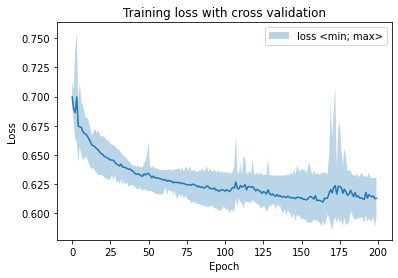

In [16]:
plt.figure()
plt.title("Training loss with cross validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.fill_between(range(200), train_loss.min(0), train_loss.max(0), alpha=0.3, label="loss <min; max>")
# plt.fill_between(range(200), train_loss.mean(0)-train_loss.std(0), train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")
# plt.plot(range(200), train_loss.mean(0)-train_loss.std(0), 'y-.', alpha=0.6, label="mean loss +- std") #, train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")
# plt.plot(range(200), train_loss.mean(0)+train_loss.std(0), 'y-.', alpha=0.6) #, train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")

plt.plot(range(200), train_loss.mean(0))
plt.legend()
plt.savefig("training_loss.png")
# plt.show()

In [ ]:
prijdte se na nas podivat
budeme se brat
mame se radi tka se bereme
mame se raditak se proste bereme
proste se bereme
pokracujeme spolu
 